# Plant model 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip' -d '/content/drive/MyDrive/plant disease'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

import keras

from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import img_to_array, load_img

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
input_folder = '/content/drive/MyDrive/plant disease/Plant_leaf_diseases_dataset_with_augmentation'

In [ ]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val, test
splitfolders.ratio(input_folder, output="/content/drive/MyDrive/plant disease", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) # default values
# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# enable oversampling of imbalanced datasets, works only with fixed
# splitfolders.fixed(input_folder, output="cell_images2", 
#                    seed=42, fixed=(35, 20), 
#                    oversample=False, group_prefix=None)

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

#Preprocessing


In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3 ,horizontal_flip=True, preprocessing_function= preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train = train_datagen.flow_from_directory(directory='/content/drive/MyDrive/plant disease/train',
                                          target_size=(256,256),
                                          batch_size=32)

val = train_datagen.flow_from_directory(directory='/content/drive/MyDrive/plant disease/val',
                                          target_size=(256,256),
                                          batch_size=32)

test = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/plant disease/train',
                                          target_size=(256,256),
                                          batch_size=32)

Found 30780 images belonging to 36 classes.
Found 8525 images belonging to 36 classes.
Found 30780 images belonging to 36 classes.


In [ ]:
t_img , label = train.next()

In [ ]:
def plotImage(img_arr,label) :

  for im, l in zip(img_arr,label) :
    plt.figure(figsize=(5,5))
    plt.imshow(im/255)
    plt.show()

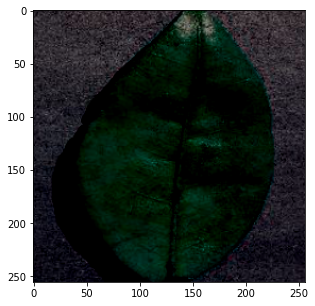

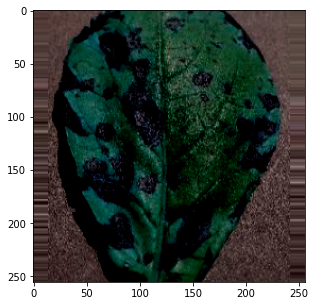

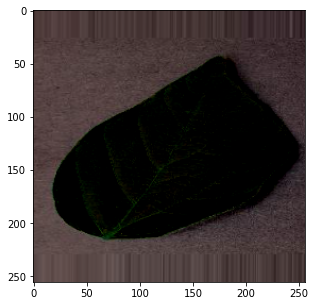

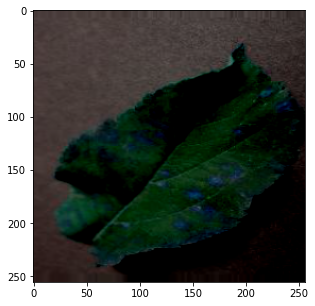

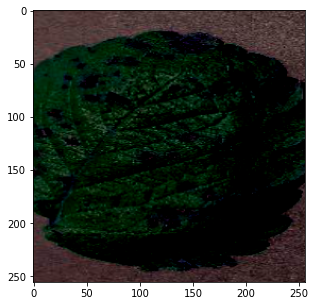

In [ ]:
plotImage(t_img[:5],label[:5])

## **Building our model**

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model 
from keras.applications.vgg19 import VGG19
import keras

In [ ]:
base_model = VGG19(input_shape=(256,256,3), include_top= False)

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
# base_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))


In [ ]:
for layer in base_model.layers :
  layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
x = Flatten()(base_model.output)

x = Dense(units=36, activation='softmax')(x)


# Creating the model
model = Model(base_model.input,x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model.compile(optimizer='adam' ,loss= tf.keras.losses.categorical_crossentropy, metrics= ['accuracy'])

#**Early Stopping and Model Check point**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Early stopping 
es = EarlyStopping(monitor= 'val_accuracy', min_delta= 0.01, patience= 3,verbose=1)

# model check point
mc = ModelCheckpoint(filepath= '/content/drive/MyDrive/plant-model/best_model.h5',
                     moniter= 'val_accuracy',
                     min_delta= 0.01, 
                     patience= 3,
                     verbose=1, 
                     save_best_only= True)

cb = [es,mc]

In [ ]:
# model.fit(
#     x=train,
#     y=None,
#     batch_size=None,
#     epochs=1,
#     verbose='auto',
#     callbacks=None,
#     # validation_split=0.0,
#     validation_data=val,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
#     steps_per_epoch=16,
#     validation_steps=16,
#     validation_batch_size=None,
#     validation_freq=1,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False
# )

#**Training Model**

In [ ]:
his = model.fit_generator(train , 
                          steps_per_epoch=16, 
                          epochs=50,
                          verbose= 1,
                          callbacks= cb, 
                          validation_data= val,
                          validation_steps= 16) 

<ipython-input-17-078f02232aa9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train ,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 5.7519 - accuracy: 0.7207 
Epoch 1: val_loss did not improve from 5.07694
16/16 [==============================] - 655s 42s/step - loss: 5.7519 - accuracy: 0.7207 - val_loss: 7.3537 - val_accuracy: 0.7031
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 4.8079 - accuracy: 0.7656 
Epoch 2: val_loss did not improve from 5.07694
16/16 [==============================] - 652s 42s/step - loss: 4.8079 - accuracy: 0.7656 - val_loss: 5.1262 - val_accuracy: 0.7520
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 5.5198 - accuracy: 0.7246 
Epoch 3: val_loss did not improve from 5.07694
16/16 [==============================] - 612s 39s/step - loss: 5.5198 - accuracy: 0.7246 - val_loss: 6.1839 - val_accuracy: 0.7695
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 6.2537 - accuracy: 0.7402 
Epoch 4: val_loss improved from 5.07694 to 4.23412, saving model to /content/drive/MyD

<!-- IF THE LOSS B\W LOSS AND VAL_LOSS IS MORE THEN OUR MODEL IS OVERFITTING -->

#Accuracy

IF THE LOSS B\W LOSSS AND VALIDATION LOSS IS MORE THAN MODEL IS OVERFITTING

In [ ]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

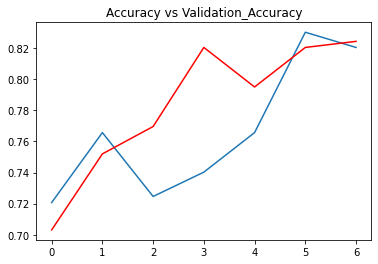

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c= "red")
plt.title("Accuracy vs Validation_Accuracy")
plt.show()

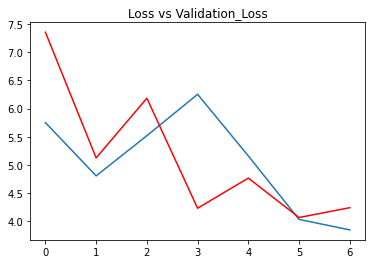

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c= "red")
plt.title("Loss vs Validation_Loss")
plt.show()

#Prediction

In [ ]:
#load best model
from keras.models import load_model

model = load_model('/content/drive/MyDrive/plant-model/best_model.h5')

In [ ]:
acc = model.evaluate_generator(test)[1]

print(f'The accuracy of model is {acc*100} %')

<ipython-input-8-a1b81704041f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(test)[1]


In [ ]:
train.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

In [ ]:
ref = dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [ ]:
def prediction(path):
  img = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis=0)
  pred = np.argmax(model.predict(img))
  print(f"Image belong to : {ref[pred]}")

In [ ]:
path = "/content/drive/MyDrive/plant disease/test/Apple___healthy/image (101).JPG"

prediction(path)

1/1 [==============================] - 0s 17ms/step
Image belong to : Apple___healthy


In [ ]:
# from tensorflow.contrib import lite
# from tensorflow import lite
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('/content/drive/MyDrive/plant-model/best_model.h5') 
model = converter.convert()
file = open( '/content/drive/MyDrive/plant-model/output.tflite' , 'wb' ) 
file.write( model )

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


84826828